In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import choice
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import seaborn as sns
from math import sqrt
from datetime import datetime

sns.set_style("whitegrid")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [2]:
dtype = {
    'BEGIN_YEARMONTH': int,
    'BEGIN_DAY': int,
    'BEGIN_TIME': 'Int64',
    'END_YEARMONTH': int,
    'END_DAY': int,
    'END_TIME': int,
    'EPISODE_ID': 'Int64',
    'EVENT_ID': 'Int64',
    'STATE': str,
    'STATE_FIPS': 'Int64',
    'YEAR': 'Int64',
    'MONTH_NAME': str,
    'EVENT_TYPE': str,
    'CZ_TYPE': str,
    'CZ_FIPS': 'Int64',
    'CZ_NAME': str,
    'WFO': str,
    'BEGIN_DATE_TIME': str,
    'CZ_TIMEZONE': str,
    'END_DATE_TIME': str,
    'INJURIES_DIRECT': 'Int64',
    'INJURIES_INDIRECT': 'Int64',
    'DEATHS_DIRECT': 'Int64',
    'DEATHS_INDIRECT': 'Int64',
    'DAMAGE_PROPERTY': str,
    'DAMAGE_CROPS': str,
    'SOURCE': str,
    'MAGNITUDE': 'Float64',
    'MAGNITUDE_TYPE': str,
    'FLOOD_CAUSE': str,
    'TOR_F_SCALE': str,
    'TOR_LENGTH': 'Float64',
    'TOR_WIDTH': 'Float64',
    'TOR_OTHER_WFO': str,
    'TOR_OTHER_CZ_STATE': str,
    'TOR_OTHER_CZ_FIPS': 'Int64',
    'TOR_OTHER_CZ_NAME': str,
    'BEGIN_RANGE': 'Float64',
    'BEGIN_AZIMUTH': str,
    'BEGIN_LOCATION': str,
    'END_RANGE': 'Float64',
    'END_AZIMUTH': str,
    'END_LOCATION': str,
    'BEGIN_LAT': 'Float64',
    'BEGIN_LON': 'Float64',
    'END_LAT': 'Float64',
    'END_LON': 'Float64',
    'EPISODE_NARRATIVE': str,
    'EVENT_NARRATIVE': str,
    'DATA_SOURCE': str,
    'TOR_F_SCALE_MAPPED': 'str',
    'DAMAGE_CROPS_DESUFFIX': 'Float64',
    'DAMAGE_PROPERTY_DESUFFIX': 'Float64'
}

tdf = pd.read_csv('../StormEvents_details_WORKING.csv',dtype=dtype)
tdf['TOR_F_SCALE_MAPPED'] = tdf.TOR_F_SCALE_MAPPED.fillna('N/A')


In [3]:
tdf.rename({'Unnamed: 0':'STORM_ID'},axis=1,inplace=True)

tdf = tdf[(~tdf['BEGIN_LAT'].isna()) & (~tdf['BEGIN_LON'].isna())]

tdf['BEGIN_YEAR'] = tdf['BEGIN_YEARMONTH'].apply(lambda ym : int(str(ym)[0:4]))
tdf['BEGIN_DECADE'] = (tdf['BEGIN_YEAR'] // 10) * 10
tdf['BEGIN_MONTH'] = tdf['BEGIN_YEARMONTH'].apply(lambda ym : int(str(ym)[-2:]))
tdf['CASUALTIES'] = tdf[['DEATHS_DIRECT','DEATHS_INDIRECT','INJURIES_DIRECT','INJURIES_INDIRECT']].sum(axis=1)
tdf['BEGIN_QUARTER'] = tdf['BEGIN_MONTH'] // 4
tdf['BEGIN_YEAR_QUARTER'] = tdf['BEGIN_YEAR'] * 10 + tdf['BEGIN_QUARTER']
tdf['FIPS'] = tdf['STATE_FIPS'] * 1000 + tdf['CZ_FIPS']
tdf['BEGIN_DATE_STR'] = tdf.apply(lambda r : str(r.BEGIN_YEARMONTH) + str(r.BEGIN_DAY),axis=1)
tdf['BEGIN_DATE'] = pd.to_datetime(tdf['BEGIN_DATE_STR'],format='%Y%m%d')
tdf['BEGIN_DAY_OF_YEAR'] = tdf['BEGIN_DATE'].dt.day_of_year
tdf['BEGIN_WEEK_OF_YEAR'] = tdf['BEGIN_DATE'].dt.week_of_year

grouped = tdf.groupby('EPISODE_ID').count().reset_index()[['EPISODE_ID','STORM_ID']]
multi_episodes = grouped[grouped['STORM_ID'] > 1]['EPISODE_ID']
tdf['CLUSTER_EPISODE_ID'] = tdf['EPISODE_ID'].apply(lambda e : e if e in multi_episodes else np.nan)

historic_lat_mean = tdf['BEGIN_LAT'].mean()
historic_lon_mean = tdf['BEGIN_LON'].mean()

# Assign orientation of a tornado to the historical mean of all tornadoes
conditions = [
    (tdf['BEGIN_LAT'] > historic_lat_mean) & (tdf['BEGIN_LON'] < historic_lon_mean),  
    (tdf['BEGIN_LAT'] <= historic_lat_mean) & (tdf['BEGIN_LON'] < historic_lon_mean), 
    (tdf['BEGIN_LAT'] <= historic_lat_mean) & (tdf['BEGIN_LON'] >= historic_lon_mean),
    (tdf['BEGIN_LAT'] > historic_lat_mean) & (tdf['BEGIN_LON'] >= historic_lon_mean)  
]

orientations = [
    0,  # NE 
    1,  # SE
    2,  # SW 
    3   # NW
    ]

# Assign orientation based on conditions
tdf['ORIENTATION_FROM_MEAN'] = np.select(conditions, orientations)    

# pull in the population of a State-County FIPS at the time of the tornado 
county_pop = pd.read_csv('../assets/county_population.csv')[['fips','county','state','year','population']]
tdf_cpop = pd.merge(tdf,county_pop, how='left', left_on=['FIPS','BEGIN_YEAR'],right_on=['fips','year'])

for col in ['population','CASUALTIES','TOR_WIDTH','TOR_LENGTH']:
    tdf_cpop['LOG_'+col.upper()] = np.log10(tdf_cpop[col])

# Omit tornadoes without Population figures
tdf_cpop = tdf_cpop[
    (
        ~tdf_cpop['fips'].isna()
    )]
tdf_cpop.to_csv('current_tdf_cpop.csv')

/opt/anaconda3/envs/ErdosMay2024/lib/python3.11/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/opt/anaconda3/envs/ErdosMay2024/lib/python3.11/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/opt/anaconda3/envs/ErdosMay2024/lib/python3.11/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)


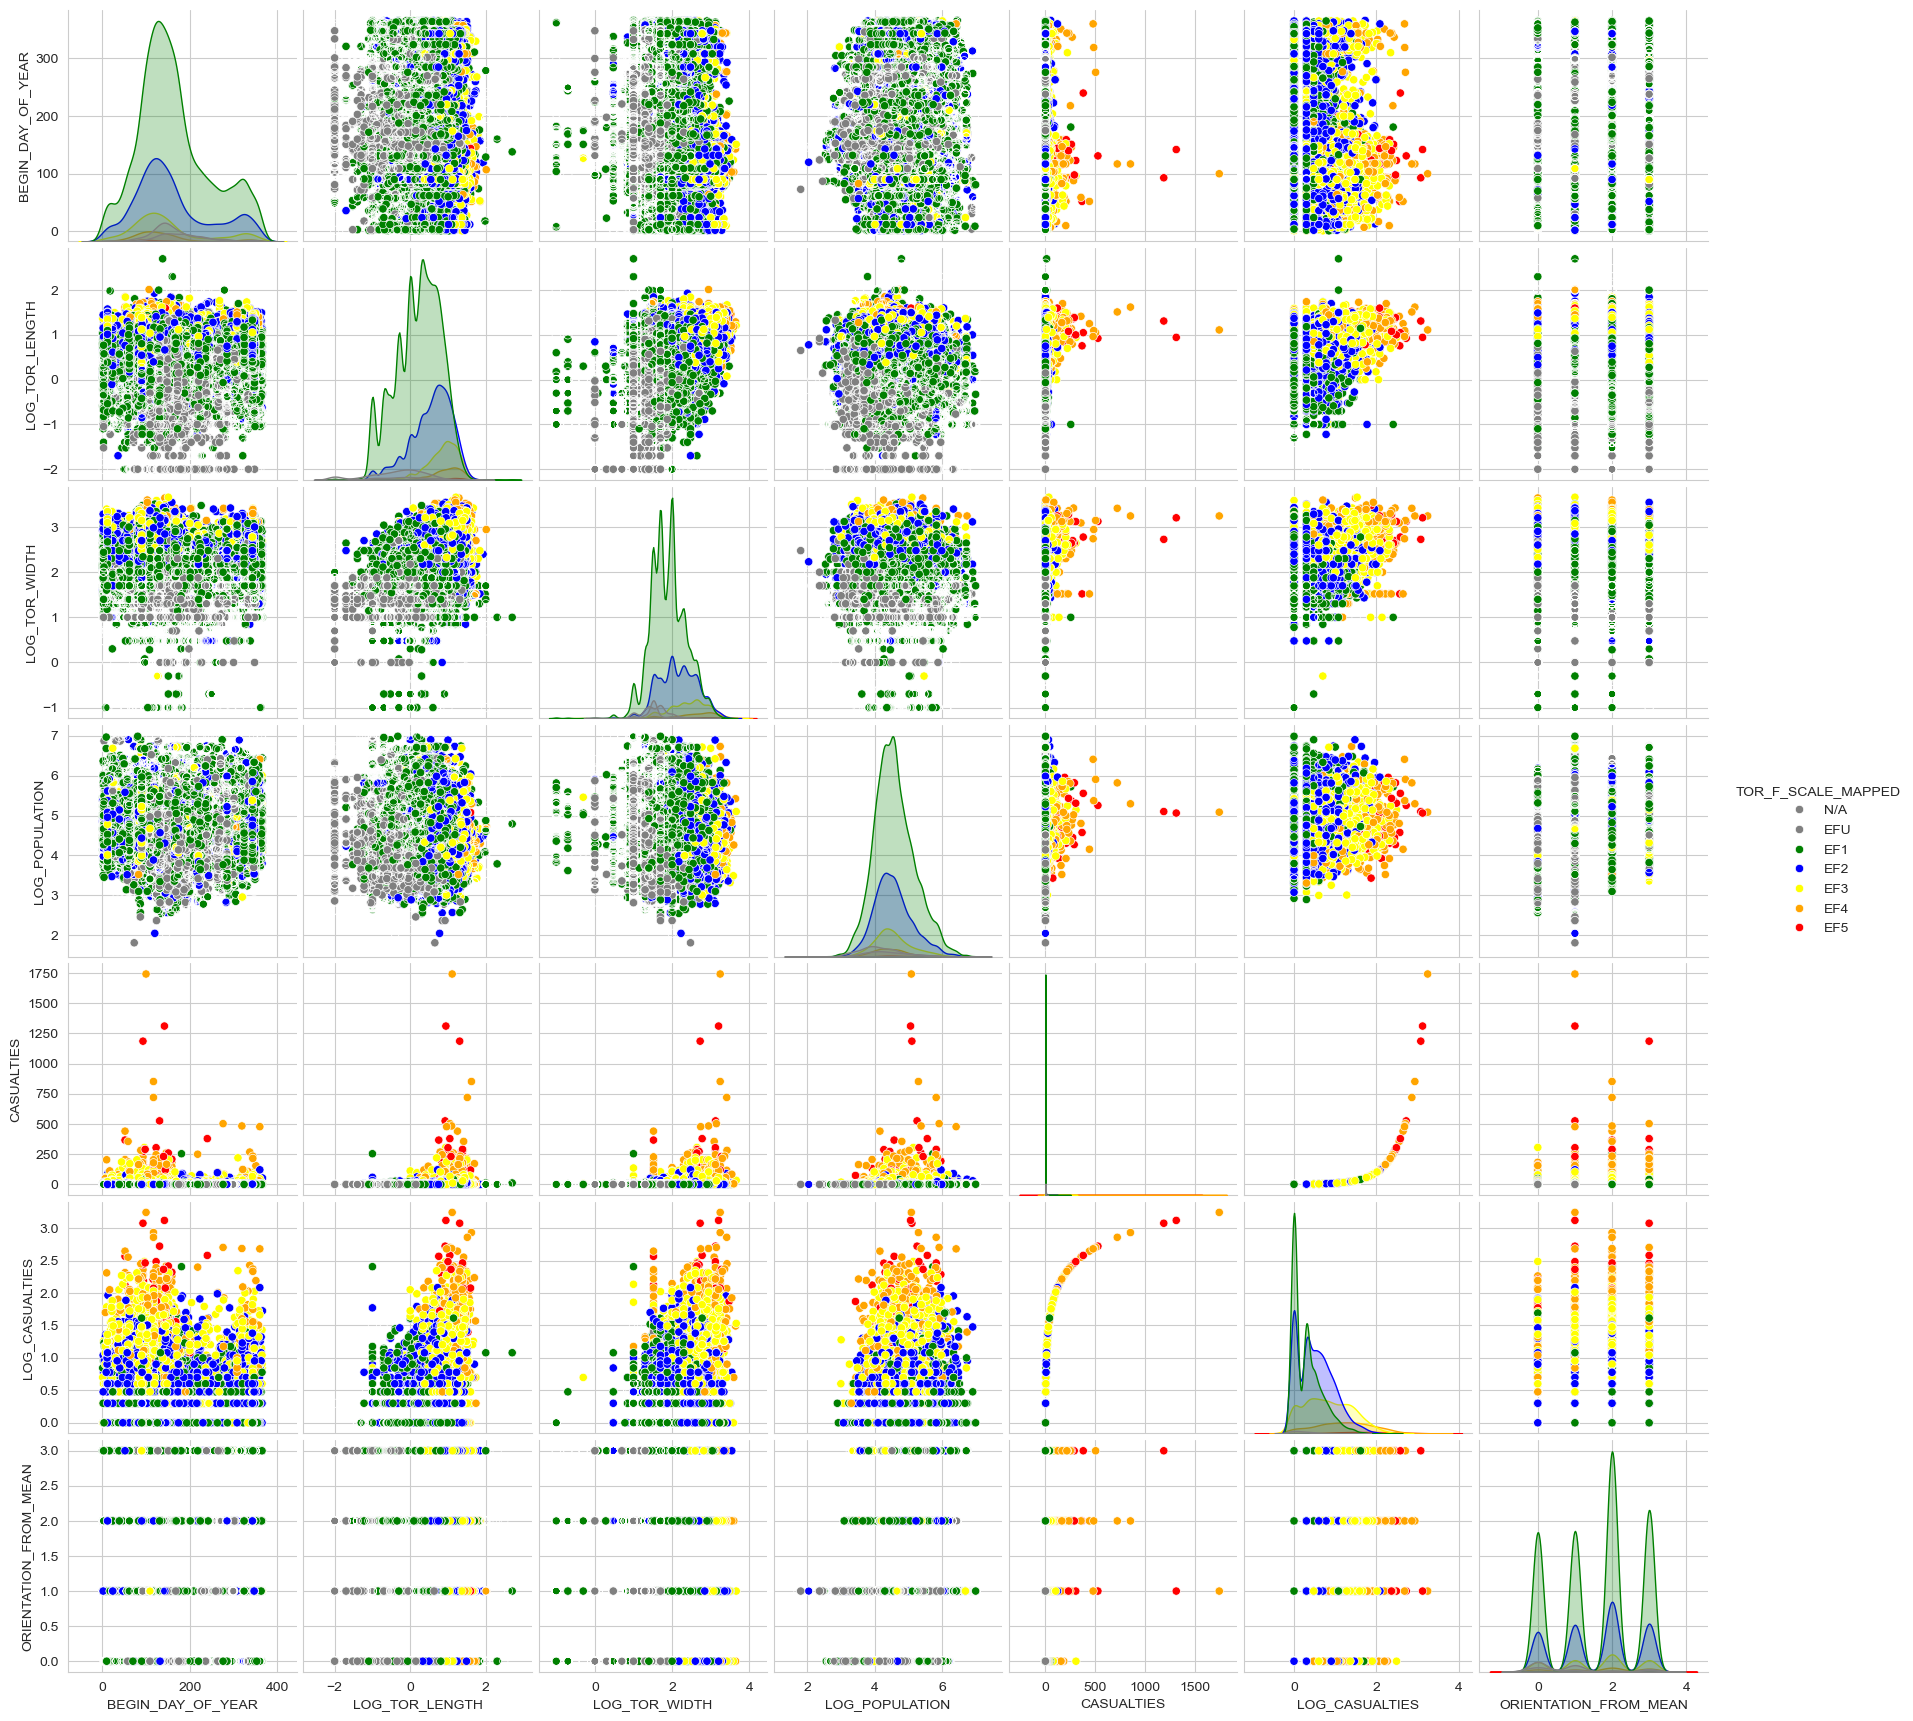

In [4]:

feats = ['BEGIN_DAY_OF_YEAR','LOG_TOR_LENGTH','LOG_TOR_WIDTH','LOG_POPULATION','CASUALTIES','LOG_CASUALTIES','ORIENTATION_FROM_MEAN']
sns.pairplot(data=tdf_cpop,
    x_vars=feats,
    y_vars=feats,
    hue='TOR_F_SCALE_MAPPED',
    palette={'N/A':'grey','EFU':'grey','EF1':'green','EF2':'blue','EF3':'yellow','EF4':'orange','EF5':'red'},
    hue_order=['N/A','EFU','EF1','EF2','EF3','EF4','EF5']
)
plt.show()

* Are tornadoes moving toward more densely populated areas (is there a correlation btwn year and SE-ness)
* Do tornadoes bring more casualties to more densely populated areas? (Corr btw casualties and density)
* Are per-tornado fatality rates increasing? (Is mean casualty correlated with year?)
* Train a model that says "What are the expected casualties of an EF $X$, in a county with a density of $Y$, with an orientation of $Z$ to the historical mean, $A$ miles from the mean"
* Is Tornado Season moving? 

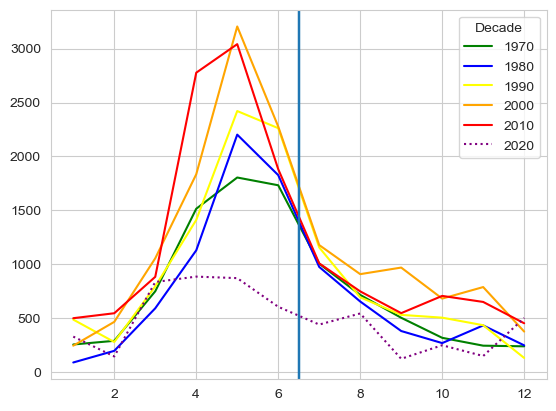

In [5]:
foo = tdf_cpop[['BEGIN_DAY_OF_YEAR','BEGIN_MONTH','EVENT_ID','TOR_F_SCALE_MAPPED','BEGIN_YEAR','BEGIN_DECADE']].groupby(['BEGIN_MONTH','BEGIN_DECADE']).count().reset_index()

colors = {
    1970:'green',
    1980:'blue',
    1990:'yellow',
    2000:'orange',
    2010:'red',
    2020:'purple',
}

linestyle = {decade: 'dotted' if decade == 2020 else 'solid' for decade in colors.keys()}

for decade in foo['BEGIN_DECADE'].unique():
    bar = foo[foo['BEGIN_DECADE'] == decade]
    plt.plot(
        bar['BEGIN_MONTH'],
        bar['EVENT_ID'],
        label=decade,
        c=colors[decade],
        linestyle=linestyle[decade]
    )
    plt.axvline(
        x=bar['BEGIN_MONTH'].mean(),
        color=colors[decade],
        linestyle=linestyle[decade])

plt.legend(title='Decade')
plt.show()

In [7]:
bar.EVENT_ID.mean()

471.5

# CONVEX HULL CALCULATIONS
Uses Jarvis march to build a convex hull containing all points $s$ in a set of points $S$.

In [ ]:
class Point:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
    
def leftmost_point(points):
    return min(points, key = lambda p: p.x)

def is_ccw(p0,p1,p2):
    # returns true if p1 is ccw to p0 relative to p2
    A = np.array([p0.x,p0.y])
    B = np.array([p1.x,p1.y])
    C = np.array([p2.x,p2.y])
    return np.cross(B - A, C - A) < 0

def convex_hull(point_list):
    first_point = leftmost_point(point_list)
    hull_ids = [point_list.index(first_point)]
    start = leftmost_point(point_list)

    target = choice(point_list)
    while target == start:
        target = choice(point_list)
    working_pl = point_list.copy()

    while first_point.id != target.id:
        target = working_pl[0]
        for p in working_pl:
            if (is_ccw(start,p,target)):
                target = p
        hull_ids.append(point_list.index(target))
        start = target
        del(working_pl[working_pl.index(target)])
    return hull_ids


In [ ]:

decades = tdf.BEGIN_DECADE.unique()
decade_hulls = {}

for dec in decades: 
    decade_data = tdf[(tdf['BEGIN_DECADE'] == dec)]
    point_list = [Point(*p) for p in zip(decade_data.index, decade_data.BEGIN_LAT, decade_data.BEGIN_LON)]
    hull_ids = convex_hull(point_list)
    decade_hulls[dec] = hull_ids

In [ ]:
cmap = plt.get_cmap('rainbow')
color_decade_hulls = {}
length = len(decade_hulls) 
for idx, decade in enumerate(decade_hulls.keys()):
    color = list(cmap(idx / length)) # the same as normalizing #
    color[3] = .9    # adds a 20% opacity to the colors
    color_decade_hulls[decade] = {
        'color': color,
        'hull_ids': decade_hulls[decade]
    }
fig, ax = plt.subplots(length,1, sharex=True, sharey=True, figsize=(4,16))

patches = []
idx = 0
for decade, data in color_decade_hulls.items():
    hull_ids = data['hull_ids']
    
    decade_data = tdf[(tdf['BEGIN_DECADE'] == decade)]
    point_list = [Point(*p) for p in zip(decade_data.index, decade_data.BEGIN_LAT, decade_data.BEGIN_LON)]

    polygon = Polygon([[point_list[i].x,point_list[i].y] for i in hull_ids], closed=True, color = data['color'])
    p = PatchCollection([polygon], match_original=True)
    ax[idx].add_collection(p)
    ax[idx].set_title(str(decade) + 's')
    idx +=1

ax = plt.gca()
ax.set_xlim([tdf['BEGIN_LAT'].min() * .95, tdf['BEGIN_LAT'].max() * 1.05])
ax.set_ylim([-160, -10])

plt.show()